In [217]:
import pandas as pd
import numpy as np
# as per https://dash.plotly.com/layout
from dash import Dash, html, dcc
import plotly.express as px


This module we'll be looking at the New York City tree census. This data was provided by a volunteer driven census in 2015, and we'll be accessing it via the socrata API. The main site for the data is [here](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh), and on the upper right hand side you'll be able to see the link to the API.

The data is conveniently available in json format, so we should be able to just read it directly in to Pandas:

In [11]:
url = 'https://data.cityofnewyork.us/resource/nwxe-4ae8.json'
trees = pd.read_json(url)
trees.head(10)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
0,180683,348711,2015-08-27,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,2015-09-03,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,2015-09-05,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,2015-09-05,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,2015-08-30,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.4260,39.0,165.0,3025654.0,3.010850e+09
5,190422,106099,2015-08-30,11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,1014500,New York,40.770046,-73.984950,9.884187e+05,219825.5227,3.0,145.0,1076229.0,1.011310e+09
6,190426,106099,2015-08-30,11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,1014500,New York,40.770210,-73.985338,9.883112e+05,219885.2785,3.0,145.0,1076229.0,1.011310e+09
7,208649,103940,2015-09-07,9,0,OnCurb,Alive,Good,Tilia americana,American linden,...,1012700,New York,40.762724,-73.987297,9.877691e+05,217157.8561,3.0,133.0,1086093.0,1.010410e+09
8,209610,407443,2015-09-08,6,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,5006400,New York,40.596579,-74.076255,9.630732e+05,156635.5542,NaN,NaN,NaN,NaN
9,192755,207508,2015-08-31,21,0,OffsetFromCurb,Alive,Fair,Platanus x acerifolia,London planetree,...,3037402,New York,40.586357,-73.969744,9.926537e+05,152903.6306,47.0,37402.0,3320727.0,3.072350e+09


Looks good, but lets take a look at the shape of this data:

In [12]:
trees.shape

(1000, 45)

1000 seems like too few trees for a city like New York, and a suspiciously round number. What's going on?

Socrata places a 1000 row limit on their API. Raw data is meant to be "paged" through for applications, with the expectation that a UX wouldn't be able to handle a full dataset. 

As a simple example, if we had a mobile app with limited space that only displayed trees 5 at a time, we could view the first 5 trees in the dataset with the url below:

In [13]:
firstfive_url = 'https://data.cityofnewyork.us/resource/nwxe-4ae8.json?$limit=5&$offset=0'
firstfive_trees = pd.read_json(firstfive_url)
firstfive_trees

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
0,180683,348711,2015-08-27,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29,739,4052307,4022210001
1,200540,315986,2015-09-03,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19,973,4101931,4044750045
2,204026,218365,2015-09-05,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34,449,3338310,3028870001
3,204337,217969,2015-09-05,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34,449,3338342,3029250001
4,189565,223043,2015-08-30,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39,165,3025654,3010850052


If we wanted the next 5, we would use this url:

In [14]:
nextfive_url = 'https://data.cityofnewyork.us/resource/nwxe-4ae8.json?$limit=5&$offset=5'
nextfive_trees = pd.read_json(nextfive_url)
nextfive_trees

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
0,190422,106099,2015-08-30,11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,1014500,New York,40.770046,-73.984950,988418.6997,219825.5227,3.0,145.0,1076229.0,1.011310e+09
1,190426,106099,2015-08-30,11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,1014500,New York,40.770210,-73.985338,988311.1900,219885.2785,3.0,145.0,1076229.0,1.011310e+09
2,208649,103940,2015-09-07,9,0,OnCurb,Alive,Good,Tilia americana,American linden,...,1012700,New York,40.762724,-73.987297,987769.1163,217157.8561,3.0,133.0,1086093.0,1.010410e+09
3,209610,407443,2015-09-08,6,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,5006400,New York,40.596579,-74.076255,963073.1998,156635.5542,NaN,NaN,NaN,NaN
4,192755,207508,2015-08-31,21,0,OffsetFromCurb,Alive,Fair,Platanus x acerifolia,London planetree,...,3037402,New York,40.586357,-73.969744,992653.7253,152903.6306,47.0,37402.0,3320727.0,3.072350e+09


You can read more about paging using the Socrata API [here](https://dev.socrata.com/docs/paging.html)

In these docs, you'll also see more advanced functions (called `SoQL`) under the "filtering and query" section. These functions should be reminding you of SQL.

Think about the shape you want your data to be in before querying it. Using `SoQL` is a good way to avoid the limits of the API. For example, using the below query I can easily obtain the count of each species of tree in the Bronx:

In [15]:
boro = 'Bronx'
soql_url = ('https://data.cityofnewyork.us/resource/nwxe-4ae8.json?' +\
        '$select=spc_common,count(tree_id)' +\
        '&$where=boroname=\'Bronx\'' +\
        '&$group=spc_common').replace(' ', '%20')
soql_trees = pd.read_json(soql_url)

soql_trees

,count_tree_id,spc_common
0,4619,NaN
1,43,black walnut
2,9,spruce
3,62,tulip-poplar
4,7,trident maple
...,...,...
128,195,crimson king maple
129,774,purple-leaf plum
130,363,sawtooth oak
131,505,willow oak


This behavior is very common with web APIs, and I think this is useful when thinking about building interactive data products. When in a Jupyter Notebook or RStudio, there's an expectation that (unless you're dealing with truly large datasets) the data you want can be brought in memory and manipulated.

Dash and Shiny abstract away the need to distinguish between client side and server side to make web development more accessible to data scientists. This can lead to some unintentional design mistakes if you don't think about how costly your callback functions are (for example: nothing will stop you in dash from running a costly model triggered whenever a dropdown is called.)

The goal of using the Socrata is to force you to think about where your data operations are happening, and not resort to pulling in the data and performing all operations in local memory.

----------

**NOTE**: One tip in dealing with URLs: you may need to replace spaces with `'%20'`. I personally just write out the url and then follow the string with a replace:

In [16]:
'https://api-url.com/?query with spaces'.replace(' ', '%20')

'https://api-url.com/?query%20with%20spaces'

## **Module 4**

In this module we’ll be looking at data from the New York City tree census:

https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh

This data is collected by volunteers across the city, and is meant to catalog information
about every single tree in the city.

Build a dash app for a arborist studying the health of various tree species (as defined by the
variable ‘spc_common’) across each borough (defined by the variable ‘borough’). This
arborist would like to answer the following two questions for each species and in each
borough:

1. What proportion of trees are in good, fair, or poor health according to the ‘health’
variable?

2. Are stewards (steward activity measured by the ‘steward’ variable) having an impact
on the health of trees?

Please see the accompanying notebook for an introduction and some notes on the Socrata
API.

**Deployment:** Dash deployment is more complicated than deploying shiny apps, so
deployment in this case is **optional** (and will result in extra credit). You can read instructions
on deploying a dash app to heroku here: https://dash.plot.ly/deployment


Data is available on [NYC OpenData website](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh)

![](NYC_OpenData_API.png)

# 1. What proportion of trees are in good, fair, or poor health according to the ‘health’ variable?

In [17]:
url_1 = "https://data.cityofnewyork.us/resource/uvpi-gqnh.json"

In [70]:
soql_url_1 = (url_1+"?"+\
        '$select=spc_common,boroname,health,count(spc_common)' +\
        '&$group=spc_common,boroname,health')
soql_trees_1=pd.read_json(soql_url_1+
                          '&$limit=700000').dropna().rename(columns={"spc_common": "species",
                                                                     "boroname": "borough",
                                                                     "count_spc_common": "count"})
soql_trees_1

,species,borough,health,count
0,American beech,Bronx,Fair,7
1,American beech,Bronx,Good,21
2,American beech,Bronx,Poor,3
3,American beech,Brooklyn,Fair,18
4,American beech,Brooklyn,Good,59
...,...,...,...,...
1805,willow oak,Queens,Good,650
1806,willow oak,Queens,Poor,15
1807,willow oak,Staten Island,Fair,37
1808,willow oak,Staten Island,Good,210


Useful website for dataframe manipulation used is https://pandas.pydata.org/docs/reference/index.html

**pandas.crosstab**

*pandas.crosstab(index, columns, values=None, rownames=None, colnames=None, aggfunc=None, margins=False, margins_name='All', dropna=True, normalize=False)*[source](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html)


In [68]:
(pd.crosstab(index=soql_trees_1['health'], columns='count',
                    margins=True,margins_name="Total"
                    ,dropna=True,
                    normalize=False)).rename_axis(None).rename_axis(None, axis=1)

,count,Total
Fair,616,616
Good,649,649
Poor,543,543
Total,1808,1808


# 2. Are stewards (steward activity measured by the ‘steward’ variable) having an impact on the health of trees?

In [71]:
soql_2 = (url_1+"?"+\
        '$select=spc_common,boroname,health,steward,count(spc_common)' +\
        '&$group=spc_common,boroname,health,steward')
soql_trees_2 = pd.read_json(soql_2 +
                            '&$limit=700000').dropna().rename(columns={"spc_common": "species",
                                                                                "boroname": "borough",
                                                                                "count_spc_common":"count"})
soql_trees_2

,species,borough,health,steward,count
0,Atlantic white cedar,Bronx,Good,None,36
1,purple-leaf plum,Staten Island,Fair,1or2,87
2,catalpa,Bronx,Good,4orMore,1
3,kousa dogwood,Queens,Good,None,55
4,Norway spruce,Staten Island,Good,1or2,6
...,...,...,...,...,...
4560,ash,Staten Island,Good,3or4,1
4561,sweetgum,Staten Island,Poor,None,125
4562,American linden,Manhattan,Good,4orMore,20
4563,white pine,Brooklyn,Fair,None,8


In [72]:
soql_trees_2["steward"].value_counts()

None       1719
1or2       1586
3or4        917
4orMore     332
Name: steward, dtype: int64

In [106]:
pd.crosstab(index=soql_trees_2['species'], columns=soql_trees_2['steward'])

steward,1or2,3or4,4orMore,None
species,,,,
'Schubert' chokecherry,15,12,5,15
American beech,13,5,1,15
American elm,15,11,7,15
American hophornbeam,15,9,2,15
American hornbeam,15,10,1,15
...,...,...,...,...
weeping willow,10,4,0,13
white ash,10,7,1,15
white oak,15,11,1,15


In [110]:
# Binning of the data based on a condition
soql_trees_2.loc[soql_trees_2.steward == 'None', 'Steward Available'] = 0
soql_trees_2.loc[soql_trees_2.steward != 'None', 'Steward Available'] = 1
 
# Grouping and couting
soql_trees_2.groupby('Steward Available').count()

,species,borough,health,steward,count
Steward Available,,,,,
0.0,1719,1719,1719,1719,1719
1.0,2835,2835,2835,2835,2835


In [186]:
soql_trees_2_1 = soql_trees_2.loc[:, ["health",
                                      "steward",
                                      "Steward Available"]]
soql_trees_3=soql_trees_2_1.groupby(["health",
                                     "steward",
                                     "Steward Available"], as_index=False)["Steward Available"].count()
soql_trees_3=soql_trees_3.pivot_table(index='health',columns='steward',values='Steward Available',
                                      margins=True,aggfunc=np.sum).rename_axis(None).rename_axis(None, axis=1)
soql_trees_3


,1or2,3or4,4orMore,None,All
Fair,524,291,79,589,1483
Good,622,464,220,637,1943
Poor,440,162,33,493,1128
All,1586,917,332,1719,4554


In [188]:
soql_trees_4=soql_trees_2_1.groupby(["health","Steward Available"], as_index=False)
# soql_trees_4.pivot(index='health', columns='Steward Available', values=soql_trees_4.count).rename_axis(None).rename_axis(None, axis=1)
soql_trees_4=soql_trees_4.count().pivot_table(index='health',columns='Steward Available',
                                              values='steward',margins=True,
                                              aggfunc=np.sum).rename_axis(None).rename_axis(None, axis=1).rename({0.0:'No',
                                                                                                                        1.0:'Yes'},
                                                                                                                       axis='columns')
soql_trees_4

,No,Yes,All
Fair,589,894,1483
Good,637,1306,1943
Poor,493,635,1128
All,1719,2835,4554


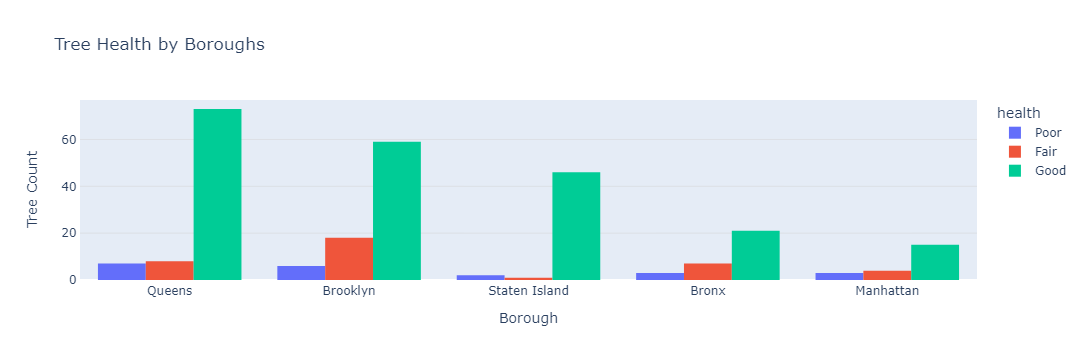

In [215]:
#1 viz
species = 'American beech' #only dynamic filter needed in the dash would be tree type
df_plot1 = soql_trees_1[(soql_trees_1['species'] == species)] 

fig = px.histogram(df_plot1, x='borough', y='count', color='health', 
                   category_orders={"health": [ "Poor","Fair","Good"]}, 
title='Tree Health by Boroughs',
labels={"borough": "Borough","count": "Count"})

fig.update_xaxes(type='category', showline=True)
fig.update_yaxes(title_text='Tree Count', showline=True, gridwidth=.5 ,gridcolor='lightgrey')
fig.update_layout(barmode='group', 
                  xaxis={'categoryorder':'total descending'})

fig.show()

In [ ]:
app = dash.Dash(__name__, external_stylesheets='yeti')

species = soql_trees_1['species'].unique()

app.layout = html.Div(children=[
    html.H1(children = 'NYC Tree Health and Stewardship Effectiveness'),
    html.P(children = 'Tree health and stewardship impact plots are generated after selecting a tree species. Data obtained from the NYC open data using SOQL commands.'),    
    html.P(children = 'Select a tree species:'),
    dcc.Dropdown(
        id='species',
        options=[{'label': s, 'value': s} for s in species],
        value=species[0] #default
    ),
    #Q1
    html.Div(id='health-app'),
    html.H2(children = 'Tree Health comparison'),
    dcc.Graph(id='health-bar'),
    #Q2
    html.Div(id='steward-app'),
    html.H2(children = 'Impact of Stewardship on Tree Health'),
    dcc.Graph(id='steward'),
    html.P(children = 'This visualization can be used to compare stewardship effectivness on tree health across the 5 boroughs'),

])

##Q1##

@app.callback(
    dash.dependencies.Output('health-bar', 'figure'), 
    [dash.dependencies.Input('species', 'value')]
)

def health_app(species):
    #filter 
    df_plot1 = soql_trees_1[(soql_trees_1['species'] == species)] 
    
    #plot begin
    fig = px.histogram(df_plot1, x='borough', y='count', color='health', #colors depend on health rating
                   category_orders={"health": ["Good","Fair", "Poor"]}, #organize health rating values
                   color_discrete_sequence=["#109618", "#FF9900", "#DC3912"], #assign and orgnize colors to match ratings
    title='American Beech tree Health throughout the 5 Boroughs',
    labels={"borough": "Borough","count": "Count"})

    fig.update_xaxes(type='category', title_text='Borough', showline=True, linewidth=.5, linecolor='lightgrey')
    fig.update_yaxes(title_text='Tree Count', showline=True, linewidth=.2, linecolor='lightgrey', gridwidth=.2 ,gridcolor='lightgrey')
    fig.update_layout(barmode='group', #plots all boroughs in a grouped bar chart for the selected tree type
                  xaxis={'categoryorder':'total descending'}, 
                  legend_title='Health Status', 
                  plot_bgcolor= 'rgba(0, 0, 0, 0)')
    return fig
    #plot end

##Q2##

@app.callback(
    dash.dependencies.Output('steward', 'figure'), 
    [dash.dependencies.Input('species', 'value')]
)

def species_app(species):
    #filter
    df_plot2 = soql_trees_2[(soql_trees_2['species'] == species)]
    
    #begin plot

    rating_color = {"#FF9900":"Fair","#109618":"Good","#DC3912": "Poor"}

    fig2 = go.Figure()

    fig2.update_layout(barmode='stack', width=900, height=800, uniformtext_minsize=8, 
                  uniformtext_mode='hide', plot_bgcolor= 'rgba(0, 0, 0, 0)', 
                  legend_title='Health Status')
    fig2.update_xaxes(linewidth=.5, linecolor='lightgrey')
    fig2.update_yaxes(linewidth=.2, linecolor='lightgrey', gridwidth=.2 ,gridcolor='lightgrey')

    for r, c in zip(df_plot2['health'].unique(), rating_color):
        df_plot = df_plot2[df_plot2['health'] == r]
        fig.add_trace(
            go.Bar(
                x=[df_plot['borough'], df_plot['steward_present']],
                y=df_plot['count'],
                marker_color=c,
                name=r,
                text=df_plot['count'],
                width=0.45,
                textposition='auto')
        )

        
    return fig2

    #end plot

if __name__ == '__main__':
       app.run_server(debug=False)